<a href="https://colab.research.google.com/github/Dangandy/backtrader-EDA/blob/master/201907_DA_WORKFLOW_03_01_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
### installs
%%bash

pip install backtrader 

In [2]:
%%bash
cat /usr/local/lib/python3.6/dist-packages/backtrader/plot/__init__.py

#!/usr/bin/env python
# -*- coding: utf-8; py-indent-offset:4 -*-
###############################################################################
#
# Copyright (C) 2015, 2016, 2017 Daniel Rodriguez
#
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <http://www.gnu.org/licenses/>.
#
###############################################################################
from __future__ import (absolute_import, division, print_function,
                 

In [0]:
%%bash
cat > /usr/local/lib/python3.6/dist-packages/backtrader/plot/__init__.py  <<'endmessage'
#!/usr/bin/env python
# -*- coding: utf-8; py-indent-offset:4 -*-
###############################################################################
#
# Removed bug to make it work in colab
#
###############################################################################
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

try:
    import matplotlib
except Exception:
    pass
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 9]

from .plot import Plot, Plot_OldSync
from .scheme import PlotScheme
endmessage

In [4]:
%%bash
cat /usr/local/lib/python3.6/dist-packages/backtrader/plot/__init__.py

#!/usr/bin/env python
# -*- coding: utf-8; py-indent-offset:4 -*-
###############################################################################
#
# Removed bug to make it work in colab
#
###############################################################################
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

try:
    import matplotlib
except Exception:
    pass
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 9]

from .plot import Plot, Plot_OldSync
from .scheme import PlotScheme


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import backtrader as bt
import backtrader.analyzers as btanalyzers
import backtrader.plot
import matplotlib
matplotlib.use('agg')

In [0]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [17, 7]

# Strategy

In [0]:
# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ("atr_period", 6),
        ("maperiod", 6),
        ("short_ma_period", 75),
        ("long_ma_period", 200),
        ("printlog", False),
    )

    def log(self, txt, dt=None, doprint=False):
        """ Logging function fot this strategy"""
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print("%s, %s" % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.target = None
        self.stoploss = None

        # Add a MovingAverageSimple indicator
        self.sma1 = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.short_ma_period
        )

        self.sma2 = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.long_ma_period
        )

        # triple moving average
        self.tema = bt.indicators.TEMA(
            self.datas[0], period=self.params.maperiod
        )

        # atr
        self.atr = bt.indicators.ATR(self.datas[0], period=self.params.atr_period)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    f"BUY EXECUTED, Price: {order.executed.price}, Cost: {order.executed.value}, Comm: {order.executed.comm}"
                )

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
                self.target = self.dataclose[0] + self.atr * 2.72
                self.stoploss = self.dataclose[0] - self.atr * 1.42
            else:  # Sell
                self.log(
                    f"SELL EXECUTED, Price: {order.executed.price}, Cost: {order.executed.value}, Comm: {order.executed.comm}"
                )

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log("Order Canceled/Margin/Rejected")

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log(f"OPERATION PROFIT, GROSS {trade.pnl}, NET {trade.pnlcomm}")

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log(f"Close, {self.dataclose[0]}")

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.sma1 > self.sma2:

                if self.dataclose[0] > self.tema:

                    # BUY, BUY, BUY!!! (with all possible default parameters)
                    self.log(f"BUY CREATE, {self.dataclose[0]}")

                    # Keep track of the created order to avoid a 2nd order
                    self.order = self.buy()

        else:

            if self.sma1 < self.sma2:
                
                if self.dataclose[0] < self.tema:
                    # SELL, SELL, SELL!!! (with all possible default parameters)
                    self.log(f"SELL CREATE, {self.dataclose[0]}")

                    # Keep track of the created order to avoid a 2nd order
                    self.order = self.sell()

                # target reached
                elif self.dataclose[0] >= self.target:
                  self.order = self.sell()

                # stopped out
                elif self.dataclose[0] < self.stoploss:
                  self.order = self.sell()
                

    def stop(self):
        self.log(
            f"(TEMA {self.params.maperiod}) SMA1 {self.params.short_ma_period} SMA1 {self.params.long_ma_period} Ending Value {self.broker.getvalue()}",
            doprint=True,
        )



# Baseline

In [0]:
class FixedSlippageAndCommisionScheme(bt.CommInfoBase):
    '''Use this for both slippage and commissions together'''
    params = (
        ('commission', 12),
        ('stocklike', True),
        ('commtype', bt.CommInfoBase.COMM_FIXED),
        )

    def _getcommission(self, size, price, pseudoexec):
        return self.p.commission


In [0]:
# Create a cerebro entity
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(TestStrategy)

# Load data
fname_symbol = 'CL'
folder_name = '5min'
suffix = '5min_20160103_20190405'

df = pd.read_parquet("/content/drive/My Drive/Decisive Workflow/data/CL_5min_20160103_20190405.parquet")
df = (df.resample('15min', label='left', base=18).agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'}))
df.columns = [col_name.lower() for col_name in df.columns]
df = df.dropna()

data = bt.feeds.PandasData(dataname = df['2014-01-01':'2018-01-01'])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(100000.0)

cerebro.addsizer(bt.sizers.FixedSize, stake=1000)

# We're trading futures, so we'll use the "commissions" to handle both slippage and commissions
slippage_and_comms = FixedSlippageAndCommisionScheme()
cerebro.broker.addcommissioninfo(slippage_and_comms)

# Alternatively, you can use:
# cerebro.broker.setcommission(commission=0.0)
cerebro.broker.set_slippage_fixed(.01,  slip_open=True, slip_limit=True, slip_match=True, slip_out=True)

# Get sharpe ratio
cerebro.addanalyzer(btanalyzers.SharpeRatio, _name='mysharpe')
cerebro.addanalyzer(btanalyzers.TradeAnalyzer, _name='mytrades')

In [12]:
# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
thestrats = cerebro.run()
thestrat = thestrats[0]

# Print Sharpe Ratio
print('Sharpe Ratio:', thestrat.analyzers.mysharpe.get_analysis())

# Get Trades
print('Trades:', thestrat.analyzers.mytrades.get_analysis()['total'])

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
2018-01-01, (TEMA 6) SMA1 75 SMA1 200 Ending Value 106926.0
Sharpe Ratio: OrderedDict([('sharperatio', 0.9123251398984369)])
Trades: AutoOrderedDict([('total', 129), ('open', 1), ('closed', 128)])
Final Portfolio Value: 106926.00


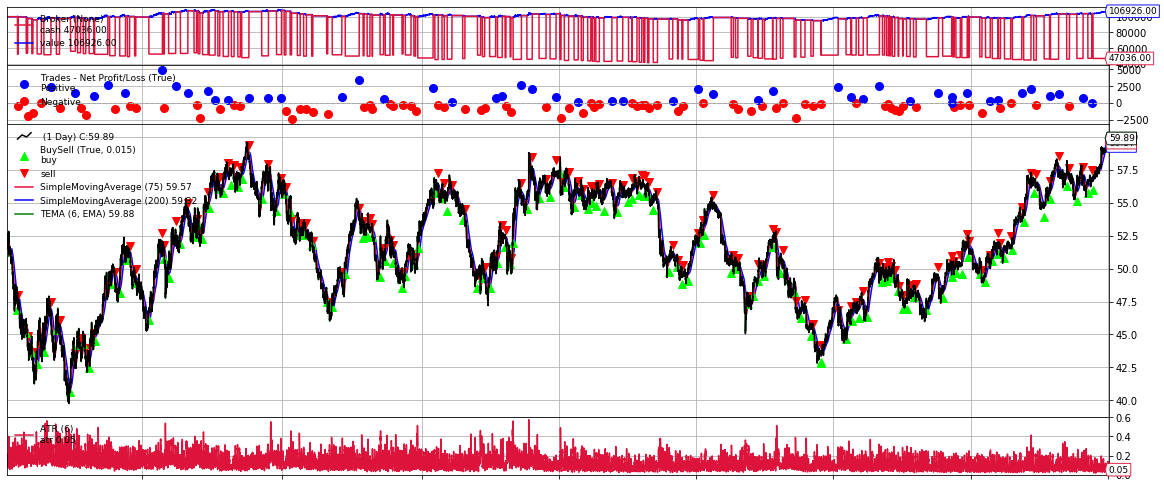

[[<Figure size 1224x504 with 4 Axes>]]

In [13]:
cerebro.plot(iplot=False, volume=False)

# In-sample Optimization

In [0]:
# build my own analyzer...
class EMAAnalyzer(bt.Analyzer):
    
    def __init__(self):
        #         ("maperiod", 6),
        # ("short_ma_period", 75),
        # ("long_ma_period", 200),
        self.maperiod = self.strategy.params.maperiod
        self.short_ma_period = self.strategy.params.short_ma_period
        self.long_ma_period = self.strategy.params.long_ma_period
        
    def start(self):
        # Not needed ... but could be used
        self.init_cash = self.strategy.broker.cash 
        self.ntrade = 0

    def next(self):
        # Not needed ... but could be used
        pass

    def notify_trade(self, trade):
        self.ntrade += 1
    
    def stop(self):
        self.final_cash = self.strategy.broker.cash
        self.final_val = self.strategy.broker.get_value()

    def get_analysis(self):
        
        outp = {
            'params': (self.maperiod, self.short_ma_period, self.long_ma_period),
            'profit': self.final_val - self.init_cash,
            'ntrade': self.ntrade
        }
        
        return outp

In [0]:
# Create a cerebro entity
cerebro = bt.Cerebro()

# Add a strategy
strats = cerebro.optstrategy(
    TestStrategy,
    maperiod=range(6, 25),
    # short_ma_period=[25,50,75],
    short_ma_period=range(25,100),
    # long_ma_period=[50,100,150,200],
    long_ma_period=range(100,200)
    )

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(100000.0)

# Add a FixedSize sizer according to the stake
cerebro.addsizer(bt.sizers.FixedSize, stake=1000)

# Get sharpe ratio
cerebro.addanalyzer(btanalyzers.SharpeRatio, _name='mysharpe')
cerebro.addanalyzer(btanalyzers.TradeAnalyzer, _name='mytrades')
cerebro.addanalyzer(EMAAnalyzer, _name='ema')

# We're trading futures, so we'll use the "commissions" to handle both slippage and commissions
slippage_and_comms = FixedSlippageAndCommisionScheme()
cerebro.broker.addcommissioninfo(slippage_and_comms)

# Run over everything
results = cerebro.run()

2018-01-01, (TEMA 6) SMA1 25 SMA1 101 Ending Value 113302.0
2018-01-01, (TEMA 6) SMA1 25 SMA1 100 Ending Value 113910.0
2018-01-01, (TEMA 6) SMA1 25 SMA1 102 Ending Value 111264.0
2018-01-01, (TEMA 6) SMA1 25 SMA1 103 Ending Value 112432.0
2018-01-01, (TEMA 6) SMA1 25 SMA1 104 Ending Value 111794.0
2018-01-01, (TEMA 6) SMA1 25 SMA1 105 Ending Value 112990.0
2018-01-01, (TEMA 6) SMA1 25 SMA1 106 Ending Value 111970.0
2018-01-01, (TEMA 6) SMA1 25 SMA1 107 Ending Value 113554.0
2018-01-01, (TEMA 6) SMA1 25 SMA1 108 Ending Value 113946.0
2018-01-01, (TEMA 6) SMA1 25 SMA1 109 Ending Value 113554.0
2018-01-01, (TEMA 6) SMA1 25 SMA1 110 Ending Value 113710.0
2018-01-01, (TEMA 6) SMA1 25 SMA1 111 Ending Value 114738.0
2018-01-01, (TEMA 6) SMA1 25 SMA1 112 Ending Value 112876.0
2018-01-01, (TEMA 6) SMA1 25 SMA1 113 Ending Value 113164.0
2018-01-01, (TEMA 6) SMA1 25 SMA1 114 Ending Value 113062.0
2018-01-01, (TEMA 6) SMA1 25 SMA1 115 Ending Value 113118.0
2018-01-01, (TEMA 6) SMA1 25 SMA1 116 En

In [0]:
params  = []
n_trades = []
profit   = []
for res in result:
    r = res[0].analyzers.ema.get_analysis()
    params.append(r['params'])
    n_trades.append(r['ntrade'])
    profit.append(r['profit'])


In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [0]:
fig, (prof, nt) = plt.subplots(1,2, figsize=(15,5))
_=prof.hist(profit, bins=np.linspace(-150,450,50))
_=nt.hist(n_trades, bins=np.arange(0,200,2))

prof.set_title('Profit Distribution')
nt.set_title('# of Trades Distribution')


In [0]:
prof_ind = np.argmax(profit) 
best_params = params[prof_ind]
print(best_params, profit[prof_ind], n_trades[prof_ind])


# In Sample

Starting Portfolio Value: 100000.00
2018-06-01, (TEMA 6) SMA1 25 SMA1 126 Ending Value 107843.99999999974
Sharpe Ratio: OrderedDict([('sharperatio', None)])
Trades: AutoOrderedDict([('total', 44), ('open', 0), ('closed', 44)])
Final Portfolio Value: 107844.00


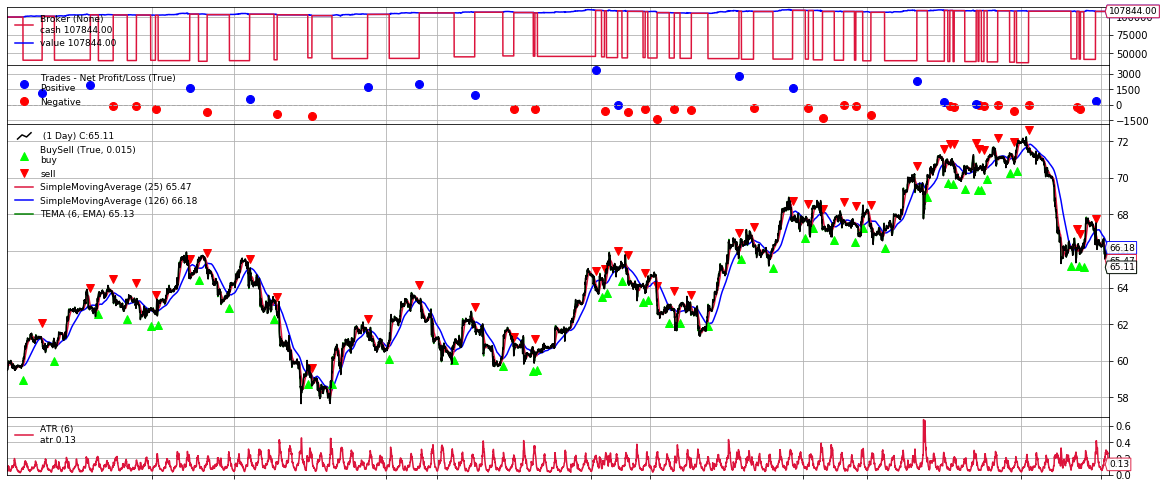

[[<Figure size 1224x504 with 4 Axes>]]

In [16]:
# Create a cerebro entity
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(TestStrategy, maperiod=6, short_ma_period=25, long_ma_period=126)

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(100000.0)

cerebro.addsizer(bt.sizers.FixedSize, stake=1000)

# We're trading futures, so we'll use the "commissions" to handle both slippage and commissions
slippage_and_comms = FixedSlippageAndCommisionScheme()
cerebro.broker.addcommissioninfo(slippage_and_comms)

# Alternatively, you can use:
# cerebro.broker.setcommission(commission=0.0)
cerebro.broker.set_slippage_fixed(.01,  slip_open=True, slip_limit=True, slip_match=True, slip_out=True)

# Get sharpe ratio
cerebro.addanalyzer(btanalyzers.SharpeRatio, _name='mysharpe')
cerebro.addanalyzer(btanalyzers.TradeAnalyzer, _name='mytrades')

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
thestrats = cerebro.run()
thestrat = thestrats[0]

# Print Sharpe Ratio
print('Sharpe Ratio:', thestrat.analyzers.mysharpe.get_analysis())

# Get Trades
print('Trades:', thestrat.analyzers.mytrades.get_analysis()['total'])

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

cerebro.plot(iplot=False, volume=False)

# Out-of-Sample

Starting Portfolio Value: 100000.00
2018-06-01, (TEMA 6) SMA1 25 SMA1 126 Ending Value 108723.99999999997
2018-06-01, (TEMA 6) SMA1 25 SMA1 126 Ending Value 108723.99999999997
Final Portfolio Value: 108724.00
Trades: AutoOrderedDict([('total', 44), ('open', 0), ('closed', 44)])
Sharpe Ratio: OrderedDict([('sharperatio', None)])


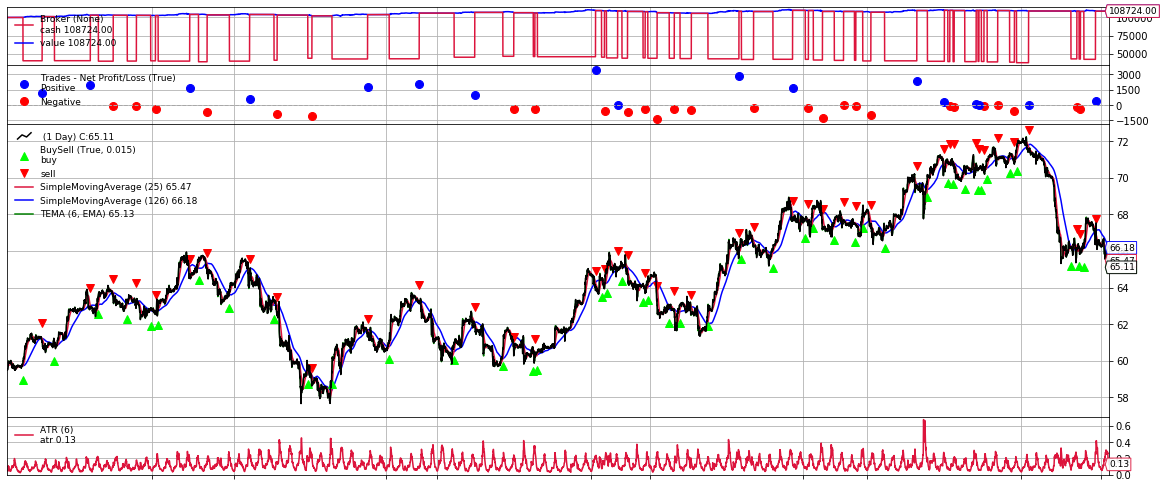

[[<Figure size 1224x504 with 4 Axes>]]

In [17]:
# Create a cerebro entity
cerebro = bt.Cerebro()

# Add a strategy
# 2018-01-01, (TEMA 6) SMA1 25 SMA1 126 Ending Value 116774.0
cerebro.addstrategy(TestStrategy, maperiod=6, short_ma_period=25, long_ma_period=126)

data = bt.feeds.PandasData(dataname = df['2018-01-01':'2018-06-01'])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(100000.0)
cerebro.addsizer(bt.sizers.FixedSize, stake=1000)

# We're trading futures, so we'll use the "commissions" to handle both slippage and commissions
slippage_and_comms = FixedSlippageAndCommisionScheme()
cerebro.broker.addcommissioninfo(slippage_and_comms)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
# Get sharpe ratio
cerebro.addanalyzer(btanalyzers.TradeAnalyzer, _name='mytrades')
cerebro.addanalyzer(btanalyzers.SharpeRatio, _name='mysharpe')

# Run over everything
cerebro.run()

# Run over everything
thestrats = cerebro.run()
thestrat = thestrats[0]

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
# cerebro.plot(volume=False, iplot=False)

# Get Trades
print('Trades:', thestrat.analyzers.mytrades.get_analysis()['total'])

# Print Sharpe Ratio
print('Sharpe Ratio:', thestrat.analyzers.mysharpe.get_analysis())

cerebro.plot(iplot=False, volume=False)